# Perturbation Simulation Demo

This notebook demonstrates the perturbation framework in scsim and visualizes the relationship between control and perturbed gene expression.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scsim import PerturbationConfig, ScSim, SimulationConfig

## 1. Create Simulation with Perturbation

In [2]:
# Simulation config with activity program
config = SimulationConfig(
    ngenes=500,
    ncells=200,
    ngroups=3,
    seed=42,
    # Gene expression parameters
    mean_rate=0.3,
    mean_shape=0.6,
    libloc=11.0,
    libscale=0.2,
    # Group DE (cell type differences)
    diffexpprob=0.1,
    diffexploc=0.5,
    diffexpscale=0.5,
    # Activity program
    nproggenes=50,
    progdownprob=0.3,
    progdeloc=0.5,
    progdescale=0.5,
    progcellfrac=0.7,
    minprogusage=0.2,
    maxprogusage=0.8,
)

# Perturbation config
perturb_config = PerturbationConfig(
    strength=0.8,
    perturb_deloc=0.7,
    perturb_descale=0.5,
    perturb_downprob=0.4,
    heterogeneous_response=True,
    min_response=0.5,
    max_response=1.0,
)

# Run simulation
sim = ScSim(config).simulate()
sim.add_perturbation(perturb_config)

# Export to AnnData
adata = sim.to_anndata()
print(f"AnnData shape: {adata.shape}")
print(f"Conditions: {adata.obs['condition'].value_counts().to_dict()}")

AnnData shape: (400, 500)
Conditions: {'control': 200, 'perturbed': 200}


## 2. Identify Gene Categories

In [3]:
# Categorize genes
stable_genes = adata.var_names[~adata.var["is_de"] & ~adata.var["prog_gene"]].tolist()
prog_genes_not_de = adata.var_names[adata.var["prog_gene"] & ~adata.var["is_de"]].tolist()
de_genes = adata.var_names[adata.var["is_de"]].tolist()

print(f"Stable genes (not program, not DE): {len(stable_genes)}")
print(f"Program genes (not perturbed): {len(prog_genes_not_de)}")
print(f"DE genes (perturbed): {len(de_genes)}")

# Show DE fold changes
de_info = adata.var.loc[de_genes, ["perturb_de_ratio"]].copy()
de_info["direction"] = np.where(de_info["perturb_de_ratio"] > 1, "up", "down")
print(f"\nDE direction: {de_info['direction'].value_counts().to_dict()}")
print(f"\nDE fold changes (sample):\n{de_info.head(10)}")

Stable genes (not program, not DE): 450
Program genes (not perturbed): 0
DE genes (perturbed): 50

DE direction: {'up': 28, 'down': 22}

DE fold changes (sample):
         perturb_de_ratio direction
Gene451          5.434872        up
Gene452          0.549645      down
Gene453          0.840709      down
Gene454          0.272079      down
Gene455          1.469795        up
Gene456          0.320530      down
Gene457          2.996358        up
Gene458          3.242287        up
Gene459          2.096788        up
Gene460          0.550881      down


## 3. Split Control and Perturbed Data

In [4]:
# Split by condition
control_mask = adata.obs["condition"] == "control"
perturbed_mask = adata.obs["condition"] == "perturbed"

control_data = adata[control_mask].copy()
perturbed_data = adata[perturbed_mask].copy()

# Convert to DataFrames with cell_id as index for easy matching
control_df = pd.DataFrame(
    control_data.X,
    index=control_data.obs["cell_id"].values,
    columns=adata.var_names,
)
perturbed_df = pd.DataFrame(
    perturbed_data.X,
    index=perturbed_data.obs["cell_id"].values,
    columns=adata.var_names,
)

# Ensure same order
perturbed_df = perturbed_df.loc[control_df.index]

print(f"Control shape: {control_df.shape}")
print(f"Perturbed shape: {perturbed_df.shape}")
print(f"Cell IDs match: {(control_df.index == perturbed_df.index).all()}")

Control shape: (200, 500)
Perturbed shape: (200, 500)
Cell IDs match: True


## 4. Scatterplots: Control vs Perturbed (Across Cells)

For each gene, plot control expression vs perturbed expression across all matched cell pairs.

In [5]:
def plot_gene_scatter(gene_name, control_df, perturbed_df, ax, color="blue"):
    """Scatter plot of control vs perturbed expression for one gene."""
    x = control_df[gene_name].values
    y = perturbed_df[gene_name].values
    
    ax.scatter(x, y, alpha=0.5, s=10, c=color)
    
    # Add diagonal line
    max_val = max(x.max(), y.max())
    ax.plot([0, max_val], [0, max_val], "k--", alpha=0.5, label="y=x")
    
    # Correlation
    corr = np.corrcoef(x, y)[0, 1]
    ax.set_title(f"{gene_name}\nr={corr:.3f}")
    ax.set_xlabel("Control")
    ax.set_ylabel("Perturbed")

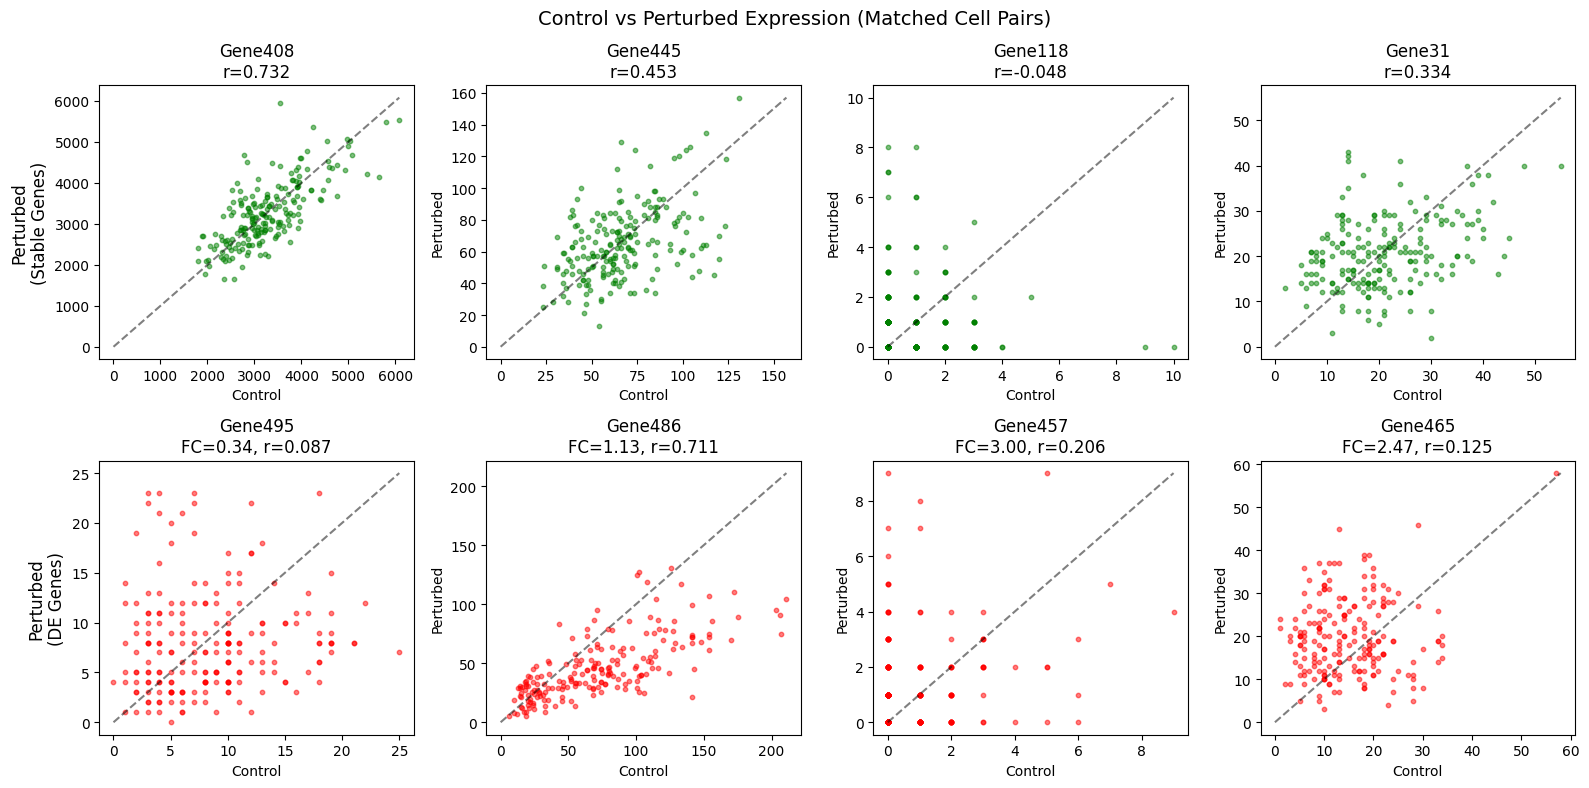

In [6]:
# Select example genes from each category
np.random.seed(42)
example_stable = np.random.choice(stable_genes, 4, replace=False)
example_de = np.random.choice(de_genes, 4, replace=False)

# Plot stable genes
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, gene in enumerate(example_stable):
    plot_gene_scatter(gene, control_df, perturbed_df, axes[0, i], color="green")
    if i == 0:
        axes[0, i].set_ylabel("Perturbed\n(Stable Genes)", fontsize=12)

for i, gene in enumerate(example_de):
    fc = adata.var.loc[gene, "perturb_de_ratio"]
    plot_gene_scatter(gene, control_df, perturbed_df, axes[1, i], color="red")
    axes[1, i].set_title(f"{gene}\nFC={fc:.2f}, r={np.corrcoef(control_df[gene], perturbed_df[gene])[0,1]:.3f}")
    if i == 0:
        axes[1, i].set_ylabel("Perturbed\n(DE Genes)", fontsize=12)

plt.suptitle("Control vs Perturbed Expression (Matched Cell Pairs)", fontsize=14)
plt.tight_layout()
plt.show()

## 5. Summary Statistics: Correlation by Gene Category

In [7]:
def compute_correlations(genes, control_df, perturbed_df):
    """Compute control-perturbed correlation for each gene."""
    correlations = []
    for gene in genes:
        corr = np.corrcoef(control_df[gene], perturbed_df[gene])[0, 1]
        correlations.append(corr)
    return np.array(correlations)

stable_corrs = compute_correlations(stable_genes, control_df, perturbed_df)
de_corrs = compute_correlations(de_genes, control_df, perturbed_df)

print(f"Stable genes - correlation: {stable_corrs.mean():.3f} ± {stable_corrs.std():.3f}")
print(f"DE genes - correlation: {de_corrs.mean():.3f} ± {de_corrs.std():.3f}")

Stable genes - correlation: nan ± nan
DE genes - correlation: 0.330 ± 0.227


/Users/marcfranquesamones/gitclones/scsim/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/marcfranquesamones/gitclones/scsim/.venv/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


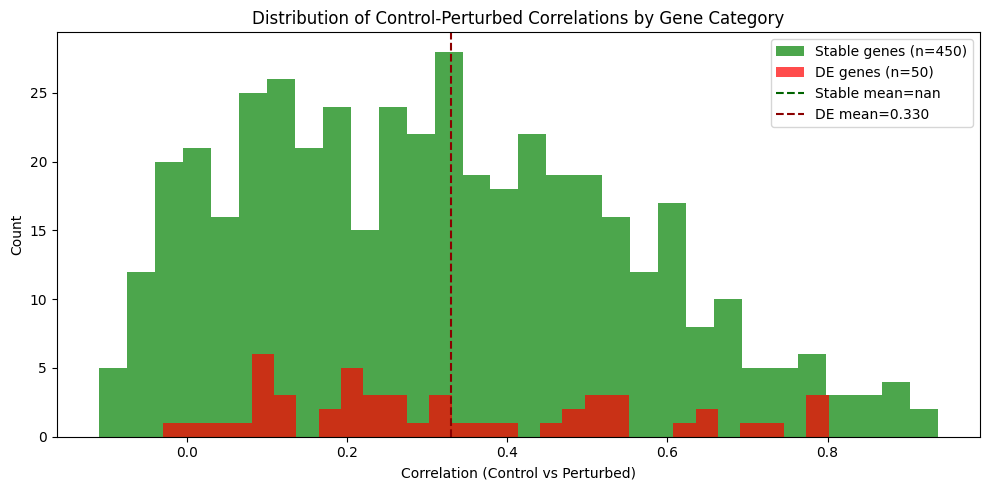

In [8]:
# Histogram of correlations
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(stable_corrs, bins=30, alpha=0.7, label=f"Stable genes (n={len(stable_genes)})", color="green")
ax.hist(de_corrs, bins=30, alpha=0.7, label=f"DE genes (n={len(de_genes)})", color="red")

ax.axvline(stable_corrs.mean(), color="darkgreen", linestyle="--", label=f"Stable mean={stable_corrs.mean():.3f}")
ax.axvline(de_corrs.mean(), color="darkred", linestyle="--", label=f"DE mean={de_corrs.mean():.3f}")

ax.set_xlabel("Correlation (Control vs Perturbed)")
ax.set_ylabel("Count")
ax.set_title("Distribution of Control-Perturbed Correlations by Gene Category")
ax.legend()
plt.tight_layout()
plt.show()

## 6. Mean Expression Shift

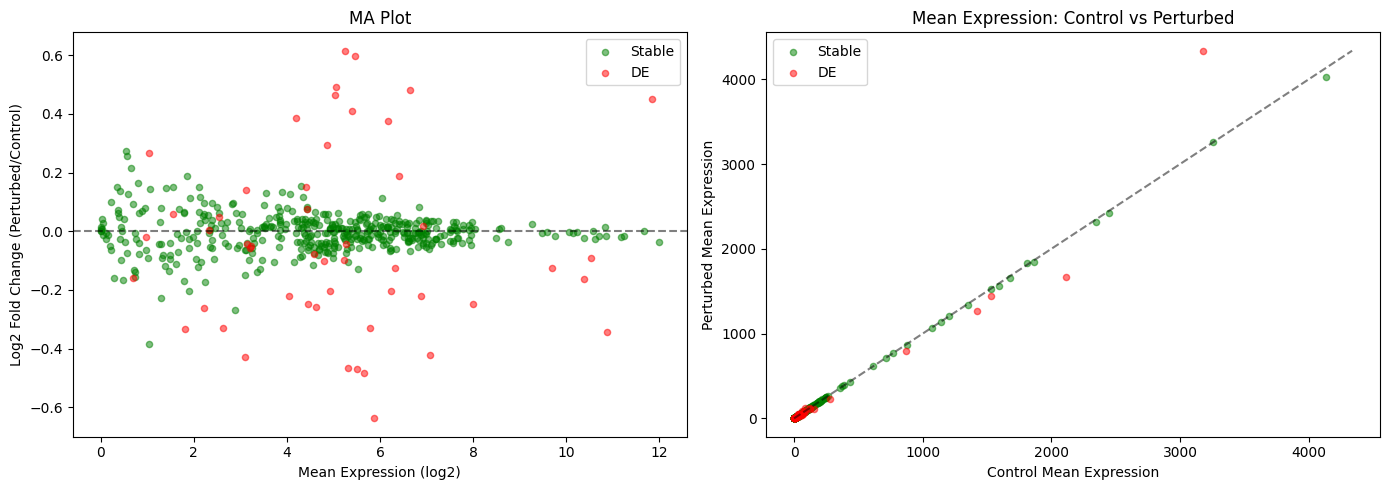

In [9]:
# Compute mean expression per gene
control_means = control_df.mean(axis=0)
perturbed_means = perturbed_df.mean(axis=0)

# Log fold change
log_fc = np.log2((perturbed_means + 1) / (control_means + 1))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MA plot style
mean_expr = (np.log2(control_means + 1) + np.log2(perturbed_means + 1)) / 2

stable_mask = adata.var_names.isin(stable_genes)
de_mask = adata.var_names.isin(de_genes)

axes[0].scatter(mean_expr[stable_mask], log_fc[stable_mask], alpha=0.5, s=20, c="green", label="Stable")
axes[0].scatter(mean_expr[de_mask], log_fc[de_mask], alpha=0.5, s=20, c="red", label="DE")
axes[0].axhline(0, color="black", linestyle="--", alpha=0.5)
axes[0].set_xlabel("Mean Expression (log2)")
axes[0].set_ylabel("Log2 Fold Change (Perturbed/Control)")
axes[0].set_title("MA Plot")
axes[0].legend()

# Scatter: control mean vs perturbed mean
axes[1].scatter(control_means[stable_mask], perturbed_means[stable_mask], alpha=0.5, s=20, c="green", label="Stable")
axes[1].scatter(control_means[de_mask], perturbed_means[de_mask], alpha=0.5, s=20, c="red", label="DE")
max_val = max(control_means.max(), perturbed_means.max())
axes[1].plot([0, max_val], [0, max_val], "k--", alpha=0.5)
axes[1].set_xlabel("Control Mean Expression")
axes[1].set_ylabel("Perturbed Mean Expression")
axes[1].set_title("Mean Expression: Control vs Perturbed")
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Cell-Level Comparison (Matched Pairs)

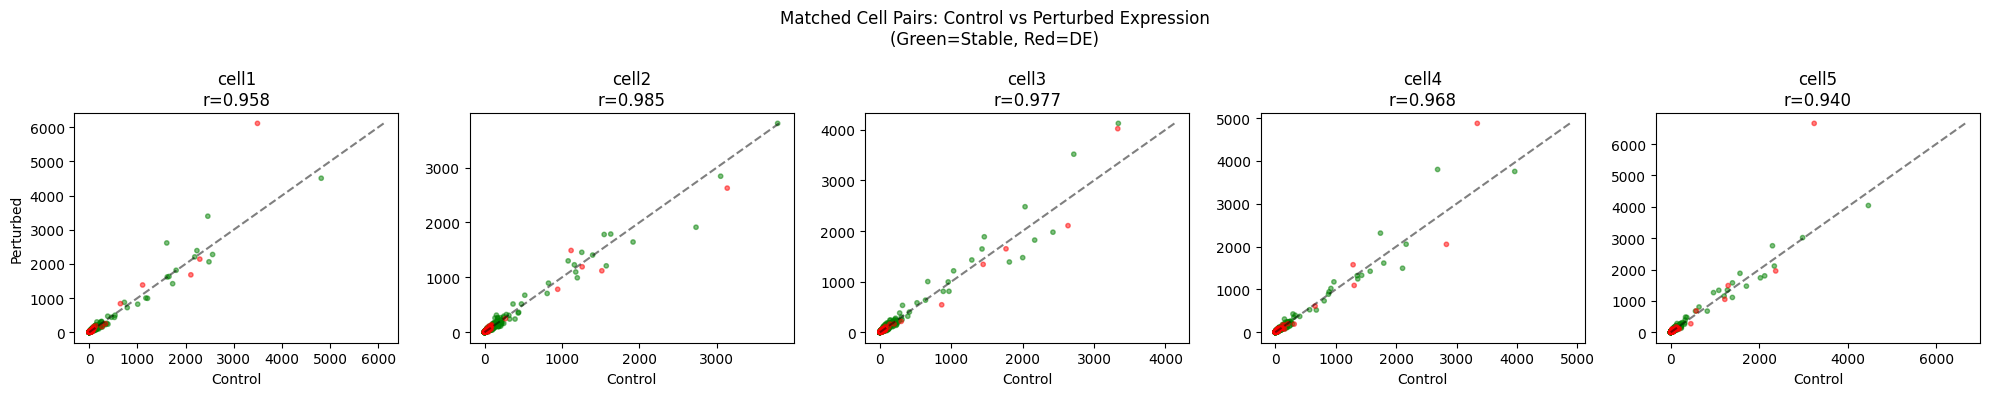

In [10]:
# For a few cells, compare their expression profile
example_cells = control_df.index[:5].tolist()

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, cell_id in enumerate(example_cells):
    ctrl = control_df.loc[cell_id]
    pert = perturbed_df.loc[cell_id]
    
    # Color by gene type
    colors = ["red" if g in de_genes else "green" for g in ctrl.index]
    
    axes[i].scatter(ctrl, pert, c=colors, alpha=0.5, s=10)
    max_val = max(ctrl.max(), pert.max())
    axes[i].plot([0, max_val], [0, max_val], "k--", alpha=0.5)
    
    corr = np.corrcoef(ctrl, pert)[0, 1]
    axes[i].set_title(f"{cell_id}\nr={corr:.3f}")
    axes[i].set_xlabel("Control")
    if i == 0:
        axes[i].set_ylabel("Perturbed")

plt.suptitle("Matched Cell Pairs: Control vs Perturbed Expression\n(Green=Stable, Red=DE)", fontsize=12)
plt.tight_layout()
plt.show()